In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'XGBoost-dart特徴量ミニマム'
notebook_name = '051'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

051_submission.csv 051


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = XGBClassifier(random_state=SEED,
                        booster='dart',
                        n_jobs=-1,
                        n_estimators=300,
                        learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['numRunners', 'inningNo', 'S', 'totalPitchingCount', 'O', 'B']


In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
    class_weight = compute_class_weight('balanced',
                                        classes=np.sort(train.y.unique()),
                                        y=y_train.values)
    class_weight = dict(
        zip(
            np.sort(train.y.unique()),
            class_weight
        )
    )
    sample_weight = y_train.map(class_weight)
    assert(sample_weight.isnull().sum() == 0)
    clf.fit(X_train, y_train.values, estimator__sample_weight=sample_weight)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



[22:17:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



**********Confusion matrix for train set (Fold 1)**********
[[1312 1382  608  466  463  369   41  425]
 [ 504 1723  316  297  323  267   28  288]
 [ 314  425  732  278  243  192   23  186]
 [ 210  290  139  597  196  121    8  148]
 [  46   55   24   26  321   33    3   32]
 [   5    8    0    0    3  131    0    3]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[252 379 145 140 139 110  12  90]
 [151 356  99  78  85  81   5  81]
 [ 87 111 121  92  87  52   2  47]
 [ 60  76  72  69  62  48   6  34]
 [ 20  20  18  24  28  11   2  12]
 [  7   4   5   8   5   6   1   1]
 [  2   0   0   1   0   0   0   0]
 [  1   7   4   2   4   2   0   4]]



C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 2)**********
[[1488 1369  514  504  477  349   53  312]
 [ 602 1688  307  297  305  241   55  251]
 [ 363  414  675  290  258  192   21  180]
 [ 219  310  174  556  180  131   20  119]
 [  43   65   30   30  304   33    8   27]
 [   5   11    1    2    6  121    2    2]
 [   0    0    0    0    0    0    9    0]
 [   0    1    0    1    0    1    0   93]]

**********Confusion matrix for validation set (Fold 2)**********
[[304 348 157 132 136  90  15  85]
 [179 358  82  78  95  61  13  70]
 [ 97 106  89  97  93  49  13  55]
 [ 81  75  60  83  53  31   9  35]
 [ 27  20  24  22  13  17   3   9]
 [  8   7   5   5   5   3   0   4]
 [  0   1   0   0   0   0   1   0]
 [  6   4   3   1   2   7   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:19:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 3)**********
[[1400 1378  564  463  468  340   94  359]
 [ 517 1721  313  312  290  256   50  287]
 [ 318  441  676  265  253  212   44  185]
 [ 214  285  163  561  190  121   34  140]
 [  32   65   26   28  317   28    9   35]
 [   2    9    0    2    2  130    2    3]
 [   0    0    0    0    0    0    9    0]
 [   2    2    0    0    2    1    0   89]]

**********Confusion matrix for validation set (Fold 3)**********
[[310 361 137 134 102  82  28 113]
 [192 366  75  84  67  55  17  80]
 [102 116 120  73  72  64  13  38]
 [ 73  89  68  73  57  36   3  29]
 [ 24  23  20  19  18  18   1  12]
 [  6  12   1   9   3   2   0   4]
 [  1   0   0   1   0   0   0   0]
 [  4   5   4   3   2   1   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:21:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 4)**********
[[1420 1288  608  546  463  322   18  402]
 [ 575 1659  352  326  269  220   18  326]
 [ 307  416  770  300  193  186   14  208]
 [ 190  292  184  640  135  112   14  142]
 [  30   62   35   25  331   28    2   27]
 [   2   10    2    1    3  127    1    3]
 [   0    0    0    0    0    0    9    0]
 [   0    3    0    0    0    0    0   93]]

**********Confusion matrix for validation set (Fold 4)**********
[[299 360 173 156 105  75   8  90]
 [144 370 105 101  95  47   8  67]
 [ 92 134 120  95  71  44   5  37]
 [ 69  80  72  74  51  33   0  48]
 [ 12  23  32  27  13  11   0  17]
 [  5   5   5   7   7   5   0   4]
 [  0   0   0   1   0   0   0   1]
 [  3   9   4   3   2   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 5)**********
[[1389 1368  478  508  541  295   51  437]
 [ 498 1730  263  306  323  221   45  359]
 [ 334  465  621  319  243  187   25  200]
 [ 192  291  140  592  183  124   28  159]
 [  38   65   26   32  300   26    5   48]
 [   4   11    1    1    6  123    1    2]
 [   0    0    0    0    0    0    9    0]
 [   0    2    1    0    0    0    0   93]]

**********Confusion matrix for validation set (Fold 5)**********
[[288 384 131 138 131  77   6 111]
 [183 383  61  70  86  65  15  74]
 [ 96 109 106  95  78  42   9  63]
 [ 64  90  70  72  53  34   4  40]
 [ 22  28  16  16  19  14   4  16]
 [  5   7   5   4   7   4   1   5]
 [  0   0   0   0   2   0   0   0]
 [  2   3   2   3   5   3   0  

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.286137,0.150945
std,0.012266,0.002667
min,0.276884,0.147237
25%,0.277764,0.149895
50%,0.281299,0.150773
75%,0.288134,0.152567
max,0.306600,0.154252


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,7,0,1
3,3,2,7,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,4,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.102849,0.121724,0.159606,0.199624,0.116227,0.126956,0.079645,0.093369,27446,1
1,0.181144,0.128156,0.166443,0.128848,0.102952,0.068591,0.124084,0.099782,113,1
2,0.152724,0.302349,0.141734,0.103494,0.083040,0.061440,0.076869,0.078349,4479,1
3,0.147041,0.269216,0.142214,0.150168,0.085721,0.053707,0.025853,0.126080,29080,1
4,0.151459,0.141769,0.204551,0.180855,0.108558,0.084361,0.037308,0.091140,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.185541,0.253286,0.127211,0.126600,0.160531,0.039733,0.030833,0.076265,24272,5
33804,0.071132,0.124862,0.162123,0.162296,0.371623,0.031869,0.022775,0.053321,29106,5
33805,0.056719,0.085884,0.179165,0.260987,0.283211,0.035117,0.019146,0.079771,20679,5
33806,0.208967,0.147919,0.124595,0.197053,0.211331,0.031770,0.022413,0.055953,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.730471,0.897342,0.740136,0.709150,0.674700,0.716191,0.160091,0.371920
1,1,1.099592,1.320114,0.618542,0.606049,0.595496,0.468225,0.134771,0.157209
2,2,0.341514,0.341437,1.087088,1.408832,0.639711,0.414960,0.235191,0.531266
3,3,0.860967,1.241403,0.520679,0.545903,0.485815,0.408918,0.153725,0.782589
4,4,1.260188,0.940825,0.618828,0.610884,0.647734,0.468667,0.152011,0.300863
...,...,...,...,...,...,...,...,...,...
33803,33803,1.027162,0.686781,0.757518,0.867892,0.621269,0.475083,0.183609,0.380686
33804,33804,1.096413,1.086967,0.503733,0.535102,1.129343,0.229659,0.106916,0.311867
33805,33805,1.178617,1.011367,0.591041,0.867464,0.598528,0.347159,0.114273,0.291551
33806,33806,0.561648,0.859951,0.606096,0.719277,0.591210,0.764846,0.519948,0.377022


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,0
...,...,...
33803,33803,0
33804,33804,4
33805,33805,0
33806,33806,1


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.237518
1    0.365032
2    0.079419
3    0.109353
4    0.110447
5    0.042268
6    0.007720
7    0.048243
Name: y, dtype: float64

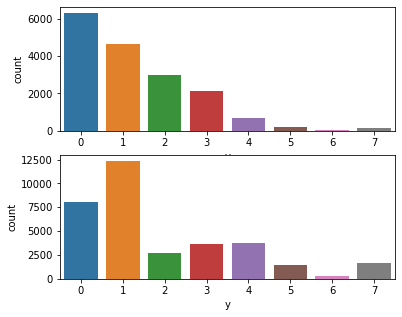

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.2861365001835994, 0.15094468806292632)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"051_submission.csv","Stratified-Kfold(K=5)","0.286137","0.150945","","XGBoost-dart特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 2.87 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 13 s


In [21]:
imp_df

,feature,importance,fold
0,numRunners,0.038837,1
1,inningNo,0.054711,1
2,S,0.067437,1
3,totalPitchingCount,0.058403,1
4,O,0.098150,1
...,...,...,...
13,isPitcherHandLeft,0.033872,5
14,isBatterPitcher,0.029202,5
15,isBottom,0.030779,5
16,batterTeam,0.047404,5


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 8 ms


In [23]:
coef_df

""
